In [773]:
!pip install nltk

In [774]:
import pandas as pd
import nltk
nltk.download('wordnet')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from sklearn.utils import class_weight
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import sys
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, GRU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from keras.callbacks import EarlyStopping



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [775]:
train_data = pd.read_csv('/content/drive/MyDrive/MachineLearningMSi/AI_capstone_Project/Ecommerce/train_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/MachineLearningMSi/AI_capstone_Project/Ecommerce/test_data.csv')
test_hidden = pd.read_csv('/content/drive/MyDrive/MachineLearningMSi/AI_capstone_Project/Ecommerce/test_data_hidden.csv')

In [776]:
train_data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [777]:
test_data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [778]:
test_hidden.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive


In [779]:
print("Number of duplicated entries in training set", train_data.duplicated().sum())
print("Number of duplicated entries in test set", test_data.duplicated().sum())
print("Number of duplicated entries in hidden test (val) set", test_hidden.duplicated().sum())

Number of duplicated entries in training set 58
Number of duplicated entries in test set 3
Number of duplicated entries in hidden test (val) set 3


In [780]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               4000 non-null   object
 1   brand              4000 non-null   object
 2   categories         4000 non-null   object
 3   primaryCategories  4000 non-null   object
 4   reviews.date       4000 non-null   object
 5   reviews.text       4000 non-null   object
 6   reviews.title      3990 non-null   object
 7   sentiment          4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB


In [781]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1000 non-null   object
 1   brand              1000 non-null   object
 2   categories         1000 non-null   object
 3   primaryCategories  1000 non-null   object
 4   reviews.date       1000 non-null   object
 5   reviews.text       1000 non-null   object
 6   reviews.title      997 non-null    object
dtypes: object(7)
memory usage: 54.8+ KB


In [782]:
test_hidden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1000 non-null   object
 1   brand              1000 non-null   object
 2   categories         1000 non-null   object
 3   primaryCategories  1000 non-null   object
 4   reviews.date       1000 non-null   object
 5   reviews.text       1000 non-null   object
 6   reviews.title      997 non-null    object
 7   sentiment          1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


In [783]:
train_data.shape, test_data.shape, test_hidden.shape

((4000, 8), (1000, 7), (1000, 8))

In [784]:
train_data = train_data.drop_duplicates() # remove the duplicates
train_data.shape

(3942, 8)

1. Aplly EDA on the dataset 

>a) See how a positive, negative and neutral reviews looks like

>b) Check the class count for each class. It's a class imbalance problem



In [785]:
positive_reviews_data = train_data[train_data['sentiment'] == 'Positive']
negative_reviews_data = train_data[train_data['sentiment'] == 'Negative']
neutral_reviews_data = train_data[train_data['sentiment'] == 'Neutral']

In [786]:
positive_reviews_data[['reviews.text', 'reviews.title']].head()

,reviews.text,reviews.title
0,Purchased on Black FridayPros - Great Price (e...,Powerful tablet
1,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME
3,"very good product. Exactly what I wanted, and ...",Greattttttt
4,This is the 3rd one I've purchased. I've bough...,Very durable!
5,This is a great product. Light weight. I wish ...,You will love it


In [787]:
positive_reviews_data['reviews.text'][0]

'Purchased on Black FridayPros - Great Price (even off sale)Very powerful and fast with quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need this to subsidize the tablet and will remove the adds if you pay them $15.Inability to access other apps except the ones from Amazon. There is a way which I was able to accomplish to add the Google Play storeNet this is a great tablet for the money'

In [788]:
negative_reviews_data[['reviews.text', 'reviews.title']].head()

,reviews.text,reviews.title
9,"was cheap, can not run chrome stuff, returned ...","was cheap, can not run chrome stuff, returned"
97,"Worthless, except as a regular echo and a poor...",Useless screen so why pay for it?
104,Too bad Amazon turned this tablet into a big a...,Amazon Fire 7 Tablet
121,I bought this Kindle for my 7 year old grand-d...,Kid's Kindle
150,I am reading positive reviews and wish I could...,Have never purchased a more frustrating Device


In [789]:
negative_reviews_data['reviews.text'][9]

'was cheap, can not run chrome stuff, returned to store.'

In [790]:
neutral_reviews_data[['reviews.text', 'reviews.title']].head()

,reviews.text,reviews.title
2,Just an average Alexa option. Does show a few ...,Average
6,My 7-year old daughter saved up to by this. He...,OK For Entry Level Tablet
17,"Not as good as before the old kindle, just sea...",Not as good as before
59,There is nothing spectacular about this item b...,"Does what it says, missing one key feature"
95,It's unfair for me to rate this product cause ...,Haven't set it up yet


In [791]:
neutral_reviews_data['reviews.text'][2]

'Just an average Alexa option. Does show a few things on screen but still limited.'

Positive    3694
Neutral      158
Negative      90
Name: sentiment, dtype: int64


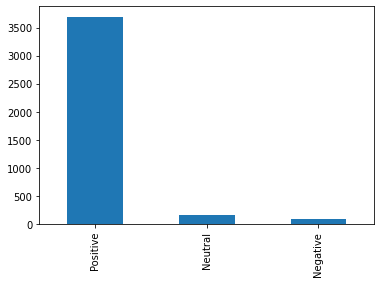

In [792]:
# Imbalance classes before removing duplicates
print(train_data.sentiment.value_counts())
train_data.sentiment.value_counts().plot(kind= 'bar')

As shown in the graph, the class imbalance problem where the number of classes varied. Positive reviewing are the highest one

In [793]:
dataCount = train_data.sentiment.value_counts()
dataCount

Positive    3694
Neutral      158
Negative      90
Name: sentiment, dtype: int64

In [794]:
(dataCount/train_data.shape[0])*100

Positive    93.708777
Neutral      4.008118
Negative     2.283105
Name: sentiment, dtype: float64

Applying onther EDA analysis for data 

In [795]:
Total_reviews = pd.DataFrame(train_data.groupby('name')['sentiment'].agg('count'))
Total_reviews

,sentiment
name,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue",35
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",56
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",628
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black",45
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",35
Amazon - Echo Plus w/ Built-In Hub - Silver,483
Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,19
"Amazon - Kindle Voyage - 6"" - 4GB - Black",65
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,20


In [796]:
pos_review_prod = pd.DataFrame(positive_reviews_data.groupby('name')['sentiment'].agg('count'))
pos_review_prod

,sentiment
name,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue",35
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",51
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",598
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black",41
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",35
Amazon - Echo Plus w/ Built-In Hub - Silver,469
Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,19
"Amazon - Kindle Voyage - 6"" - 4GB - Black",61
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,19


In [797]:
neg_review_prod = pd.DataFrame(negative_reviews_data.groupby('name')['sentiment'].agg('count'))
neg_review_prod

,sentiment
name,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",3
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",8
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black",2
Amazon - Echo Plus w/ Built-In Hub - Silver,6
"Amazon - Kindle Voyage - 6"" - 4GB - Black",1
"Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",13
"Amazon Kindle E-Reader 6"" Wifi (8th Generation, 2016)",4
Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker,8
"Brand New Amazon Kindle Fire 16gb 7"" Ips Display Tablet Wifi 16 Gb Blue",10


In [798]:
neu_review_prod = pd.DataFrame(neutral_reviews_data.groupby('name')['sentiment'].agg('count'))
neu_review_prod

,sentiment
name,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",2
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",22
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black",2
Amazon - Echo Plus w/ Built-In Hub - Silver,8
"Amazon - Kindle Voyage - 6"" - 4GB - Black",3
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,1
"Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",24
"Amazon Kindle E-Reader 6"" Wifi (8th Generation, 2016)",5
Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker,8


In [799]:
reviews_per_prod = Total_reviews.merge(pos_review_prod, on = 'name', how='outer').merge(neu_review_prod, on='name', how='outer').merge(neg_review_prod, on ='name', how='outer')
reviews_per_prod

,sentiment_x,sentiment_y,sentiment_x,sentiment_y
name,,,,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue",35,35,NaN,NaN
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",56,51,2.0,3.0
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",628,598,22.0,8.0
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black",45,41,2.0,2.0
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",35,35,NaN,NaN
Amazon - Echo Plus w/ Built-In Hub - Silver,483,469,8.0,6.0
Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,19,19,NaN,NaN
"Amazon - Kindle Voyage - 6"" - 4GB - Black",65,61,3.0,1.0
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,20,19,1.0,NaN


In [800]:
reviews_per_prod.columns=['Total_reviews', 'Positive_reviews', 'Neural_reviews', 'Negative_reviews']
reviews_per_prod

,Total_reviews,Positive_reviews,Neural_reviews,Negative_reviews
name,,,,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue",35,35,NaN,NaN
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",56,51,2.0,3.0
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",628,598,22.0,8.0
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black",45,41,2.0,2.0
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",35,35,NaN,NaN
Amazon - Echo Plus w/ Built-In Hub - Silver,483,469,8.0,6.0
Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,19,19,NaN,NaN
"Amazon - Kindle Voyage - 6"" - 4GB - Black",65,61,3.0,1.0
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,20,19,1.0,NaN


In [801]:
pd.DataFrame(train_data.categories.value_counts())

,categories
"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets",628
"Computers,Amazon Echo,Virtual Assistant Speakers,Audio & Video Components,Electronics Features,Computer Accessories,Home & Tools,See more Amazon Echo Show Smart Assistant - White,Smart Home Automation,Electronics,TVs Entertainment,Speakers,Smart Hub & Kits,Digital Device 3,Consumer Electronics,Wireless Speakers,Home Improvement,Amazon Home,Amazon,Computer Speakers,Voice-Enabled Smart Assistants",514
"Amazon Echo,Smart Home,Networking,Home & Tools,Home Improvement,Smart Home Automation,Voice Assistants,Amazon Home,Amazon,Smart Hub & Kits,Digital Device 3",483
"Computers,Fire Tablets,Electronics Features,Computer Accessories,Tablets,Top Rated,Amazon Tablets,Electronics,Kids' Tablets,iPad & Tablets,Cases & Bags,Electronics, Tech Toys, Movies, Music,Computers & Tablets",446
"Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,Tablets,All Tablets",340
"Fire Tablets,Computers/Tablets & Networking,Tablets,All Tablets,Amazon Tablets,Frys,Computers & Tablets,Tablets & eBook Readers",294
"Fire Tablets,Tablets,All Tablets,Amazon Tablets,Computers & Tablets",231
"Amazon Echo,Home Theater & Audio,MP3 MP4 Player Accessories,Electronics,Portable Audio,Compact Radios Stereos,Smart Hubs & Wireless Routers,Featured Brands,Smart Home & Connected Living,Home Security,Kindle Store,Electronic Components,Home Automation,Mobile Bluetooth Speakers,Home, Garage & Office,Amazon Tap,Home,Mobile Speakers,TVs & Electronics,Portable Bluetooth Speakers,Bluetooth & Wireless Speakers,Electronics Features,Frys,Speakers,Mobile,Digital Device 3,Smart Home,Home Improvement,Electronics, Tech Toys, Movies, Music,Smart Home & Home Automation Devices,Smart Hubs,MP3 Player Accessories,Home Safety & Security,Voice Assistants,Amazon Home,Alarms & Sensors,Portable Audio & Electronics,Amazon Devices,Audio,Bluetooth Speakers,MP3 Accessories,All Bluetooth & Wireless Speakers",177
"Amazon Echo,Virtual Assistant Speakers,Electronics Features,Home & Tools,Smart Home Automation,TVs Entertainment,Speakers,Smart Hub & Kits,Digital Device 3,Wireless Speakers,Smart Home,Home Improvement,Voice Assistants,Amazon Home,Amazon",162
"Office,eBook Readers,Electronics Features,Walmart for Business,Tablets,Electronics,Amazon Ereaders,Office Electronics,iPad & Tablets,Kindle E-readers,All Tablets,Amazon Book Reader,Computers & Tablets",122


In [802]:
pd.DataFrame(train_data.primaryCategories.value_counts())

,primaryCategories
Electronics,2562
"Electronics,Hardware",1159
"Office Supplies,Electronics",204
"Electronics,Media",17


Cleaning the data


In [803]:
train_data['reviews.date'] = pd.to_datetime(train_data['reviews.date'], utc=False).dt.date
test_data['reviews.date'] = pd.to_datetime(test_data['reviews.date'], utc=False).dt.date
test_hidden['reviews.date'] = pd.to_datetime(test_hidden['reviews.date'], utc=False).dt.date

In [804]:
train_data['reviews_day'] = pd.to_datetime(train_data['reviews.date'], utc=False).dt.day
train_data['reviews_month'] = pd.to_datetime(train_data['reviews.date'], utc=False).dt.month
train_data['reviews_year'] = pd.to_datetime(train_data['reviews.date'], utc=False).dt.year


In [805]:
test_data['reviews_day'] = pd.to_datetime(test_data['reviews.date'], utc=False).dt.day
test_data['reviews_month'] = pd.to_datetime(test_data['reviews.date'], utc=False).dt.month
test_data['reviews_year'] = pd.to_datetime(test_data['reviews.date'], utc=False).dt.year

In [806]:
test_hidden['reviews_day'] = pd.to_datetime(test_hidden['reviews.date'], utc=False).dt.day
test_hidden['reviews_month'] = pd.to_datetime(test_hidden['reviews.date'], utc=False).dt.month
test_hidden['reviews_year'] = pd.to_datetime(test_hidden['reviews.date'], utc=False).dt.year

In [807]:
train_data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,26,12,2016
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,17,1,2018
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20,Just an average Alexa option. Does show a few ...,Average,Neutral,20,12,2017
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,4,8,2017
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,23,1,2017


In [808]:
test_data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,reviews_day,reviews_month,reviews_year
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23,Amazon kindle fire has a lot of free app and c...,very handy device,23,5,2016
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,2,1,2018
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,2,1,2017
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25,"I use mine for email, Facebook ,games and to g...",Love it!!!,25,3,2017
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15,This is a fantastic item & the person I bought...,Fantastic!,15,11,2017


In [809]:
test_hidden.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23,Amazon kindle fire has a lot of free app and c...,very handy device,Positive,23,5,2016
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive,2,1,2018
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive,2,1,2017
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive,25,3,2017
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15,This is a fantastic item & the person I bought...,Fantastic!,Positive,15,11,2017


In [810]:
train_data.drop_duplicates()
test_data.drop_duplicates()
test_hidden.drop_duplicates()
print("Train_data_shape:-", train_data.shape, "test_data_shape:-", test_data.shape, "test_val_shape", test_hidden.shape)

Train_data_shape:- (3942, 11) test_data_shape:- (1000, 10) test_val_shape (1000, 11)


In [811]:
np.set_printoptions(threshold=sys.maxsize)
le = LabelEncoder()

In [812]:
#Combinig all sets datasets
Total_data = pd.concat([train_data, test_hidden, test_data], axis=0)

In [813]:
Total_data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,26,12,2016
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,17,1,2018
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20,Just an average Alexa option. Does show a few ...,Average,Neutral,20,12,2017
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,4,8,2017
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,23,1,2017


In [814]:
Total_data.shape

(5942, 11)

In [815]:
Total_data['name'] = le.fit_transform(Total_data.name)
Total_data['categories'] = le.fit_transform(Total_data.categories)
Total_data['primaryCategories'] = le.fit_transform(Total_data.primaryCategories)
Total_data['brand'] = le.fit_transform(Total_data.brand)
Total_data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
0,2,0,10,0,2016-12-26,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,26,12,2016
1,5,0,1,1,2018-01-17,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,17,1,2018
2,9,0,2,1,2017-12-20,Just an average Alexa option. Does show a few ...,Average,Neutral,20,12,2017
3,14,0,22,3,2017-08-04,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,4,8,2017
4,13,0,9,0,2017-01-23,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,23,1,2017


In [817]:
Total_data = Total_data.replace(np.nan, '', regex=True)


In [818]:
#Total_data = Total_data.fillna(Total_data.median())
#Total_data = Total_data.fillna(df_test.median())
print('df_test missing')
print(Total_data.isnull().sum()) # There are 0 missing values 

df_test missing
name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        0
sentiment            0
reviews_day          0
reviews_month        0
reviews_year         0
dtype: int64


In [819]:
#Total_data['reviews.title'].fillna(value = '999', inplace=True)
Total_data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
0,2,0,10,0,2016-12-26,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,26,12,2016
1,5,0,1,1,2018-01-17,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,17,1,2018
2,9,0,2,1,2017-12-20,Just an average Alexa option. Does show a few ...,Average,Neutral,20,12,2017
3,14,0,22,3,2017-08-04,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,4,8,2017
4,13,0,9,0,2017-01-23,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,23,1,2017


In [820]:
tok = WordPunctTokenizer()
ps = PorterStemmer()
wnl = WordNetLemmatizer()
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

In [821]:
neg_pattern = re.compile(r'\b('+ '|'.join(negations_dic.keys()) + r')\b')

In [822]:
def data_cleaner(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [823]:
import string

In [824]:
Total_data['reviews.text'] = Total_data['reviews.text'].apply(data_cleaner)

In [825]:
Total_data['reviews.title'] = Total_data['reviews.title'].apply(data_cleaner)

In [826]:
Total_data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
0,2,0,10,0,2016-12-26,purchased on black fridaypros great price eve...,powerful tablet,Positive,26,12,2016
1,5,0,1,1,2018-01-17,i purchased two amazon in echo plus and two do...,amazon echo plus awesome,Positive,17,1,2018
2,9,0,2,1,2017-12-20,just an average alexa option does show a few t...,average,Neutral,20,12,2017
3,14,0,22,3,2017-08-04,very good product exactly what i wanted and a ...,greattttttt,Positive,4,8,2017
4,13,0,9,0,2017-01-23,this is the one ive purchased ive bought one ...,very durable,Positive,23,1,2017


In [827]:
Total_data.tail()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
995,9,0,6,1,2017-12-07,we love alexa love being able to watch news br...,awesome,,7,12,2017
996,12,0,0,0,2017-01-23,speaker is pretty loud and i love that i can t...,good bluetooth device,,23,1,2017
997,15,0,17,0,2017-01-18,bought of these for my and yr old and it sa...,good product for kids,,18,1,2017
998,2,0,10,0,2016-12-12,was told by sales person i could come back in ...,was misled on price match item is okay,,12,12,2016
999,19,0,11,0,2017-06-17,i purchased this as a gift for my mother her f...,great gift,,17,6,2017


In [828]:
#Spliting the cleaned dataset into training, validation and testing set
train_data = Total_data[0:3942]
test_hidden = Total_data[3942:4942]
test_data = Total_data[4942:5942]

In [829]:
train_data.tail()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
3995,5,0,1,1,2017-12-08,it‚äôs fun for the family to play with but it ...,fun toy,Positive,8,12,2017
3996,11,0,7,0,2017-03-31,i love the kindle it is a great product it red...,great product,Positive,31,3,2017
3997,12,0,0,0,2017-01-19,i was looking for a blutooth speaker to use wi...,great dumb speaker,Positive,19,1,2017
3998,13,0,9,0,2016-05-27,this is the second amazon fire tablet i have ...,a great inch tablet at a great price,Positive,27,5,2016
3999,2,0,10,0,2016-12-30,very satisfied with tablet very fast and effic...,gets the job done,Positive,30,12,2016


In [830]:
test_data.tail()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
995,9,0,6,1,2017-12-07,we love alexa love being able to watch news br...,awesome,,7,12,2017
996,12,0,0,0,2017-01-23,speaker is pretty loud and i love that i can t...,good bluetooth device,,23,1,2017
997,15,0,17,0,2017-01-18,bought of these for my and yr old and it sa...,good product for kids,,18,1,2017
998,2,0,10,0,2016-12-12,was told by sales person i could come back in ...,was misled on price match item is okay,,12,12,2016
999,19,0,11,0,2017-06-17,i purchased this as a gift for my mother her f...,great gift,,17,6,2017


Visualizing the reviews Words text and titles in training data

In [831]:
pos_title = ' '.join([text for text in train_data['reviews.title'][train_data['sentiment']=='Positive']])

In [833]:
neg_title = ' '.join([text for text in train_data['reviews.title'][train_data['sentiment']=='Negative']])

In [834]:
neu_title = ' '.join([text for text in train_data['reviews.title'][train_data['sentiment']=='Neutral']])

In [835]:
wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=180).generate(pos_title)

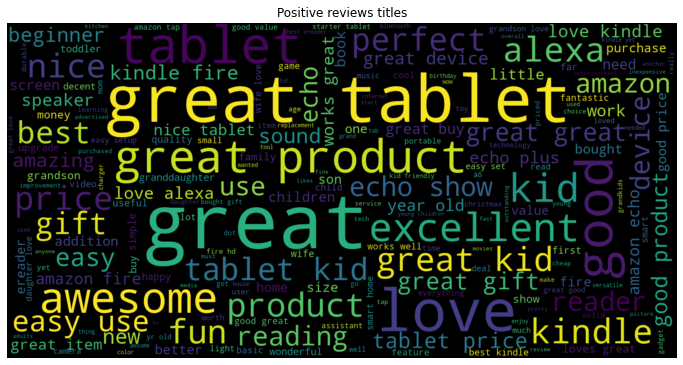

In [836]:
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive reviews titles')
plt.show()

In [837]:
wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=180).generate(neg_title)

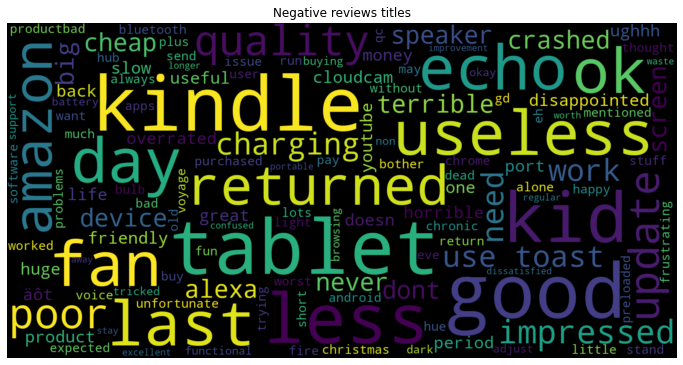

In [838]:
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative reviews titles')
plt.show()

In [839]:
wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=180).generate(neu_title)

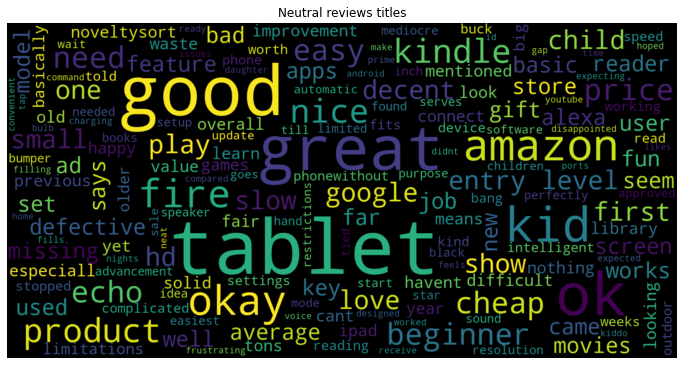

In [840]:
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral reviews titles')
plt.show()

In [698]:
#le_senti = LabelEncoder()
#train_data['sentiment'] = le_senti.fit_transform(train_data['sentiment'])
#test_hidden['sentiment'] = le_senti.fit_transform(test_hidden['sentiment'])
#print(le_senti.classes_)

In [841]:
tvec1 = TfidfVectorizer()
tvec2 = TfidfVectorizer()
tvec3 = TfidfVectorizer()

In [842]:
train1 = train_data.reset_index()

In [843]:
comi1 = train1.append(test_hidden, ignore_index=True, sort=False)


In [844]:
tvec1.fit(comi1['reviews.text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [845]:
tvec_text1 = pd.DataFrame(tvec1.transform(train1['reviews.text']).toarray())
tvec_text2 = pd.DataFrame(tvec1.transform(test_hidden['reviews.text']).toarray())

In [846]:
tvec1.fit(comi1['reviews.title'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [847]:
tvec_title1 = pd.DataFrame(tvec1.transform(train1['reviews.title']).toarray())
tvec_title2 = pd.DataFrame(tvec1.transform(test_hidden['reviews.title']).toarray())

In [848]:
Train1 = pd.concat([train1.drop(['reviews.text', 'reviews.title', 'sentiment', 'index', 'reviews.date'], axis=1), tvec_text1, tvec_title1])

In [849]:
Test_Val1 = pd.concat([test_hidden.drop(['reviews.text', 'reviews.title', 'sentiment' , 'reviews.date'], axis=1), tvec_text2, tvec_title2])

In [850]:
Train1.shape, Train1[0]

((11826, 5881), 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 3937    0.0
 3938    0.0
 3939    0.0
 3940    0.0
 3941    0.0
 Name: 0, Length: 11826, dtype: float64)

In [862]:
x_train1 = Train1.values

In [863]:
y_train1 = train_data['sentiment'].values

In [864]:
x_train1.shape, y_train1.shape

((11826, 5881), (3942,))

In [865]:
x_train1[0]

array([      nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan, 

In [854]:
x_val1 = Test_Val1.values

In [855]:
y_val1 = test_hidden['sentiment'].values

In [859]:
nb = MultinomialNB()


In [861]:
nb.fit(x_train1, y_train1)

ValueError: ignored